In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Define transformation for ViT input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Use only the first 10 images
subset_indices = list(range(10))
train_dataset = Subset(dataset, subset_indices)
test_dataset = Subset(dataset, subset_indices)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


Files already downloaded and verified


In [3]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch

# Load pre-trained ViT model with mismatched sizes ignored
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=10,
    ignore_mismatched_sizes=True
)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/digvijay/Documents/developer/ImageClassification-with-VT/.venv/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Optimizer and loss function
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

# Training function
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(pixel_values=inputs).logits
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/5, Loss: 0.0058, Accuracy: 1.0000
Epoch 2/5, Loss: 0.0058, Accuracy: 1.0000
Epoch 3/5, Loss: 0.0035, Accuracy: 1.0000
Epoch 4/5, Loss: 0.0027, Accuracy: 1.0000
Epoch 5/5, Loss: 0.0021, Accuracy: 1.0000


In [10]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Check if the model requires pixel_values argument (ViT) or not (ResNet)
        if hasattr(model, "pixel_values"):
            outputs = model(pixel_values=inputs).logits
        else:
            outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

def evaluate(model, data_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Check if the model requires pixel_values argument (ViT) or not (ResNet)
            if hasattr(model, "pixel_values"):
                outputs = model(pixel_values=inputs).logits
            else:
                outputs = model(inputs)

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total



In [11]:
import torchvision.models as models
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Load pre-trained ResNet-101 and adjust for CIFAR-10 (10 classes)
resnet_model = models.resnet101(pretrained=True)
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 10)  # Update the final layer for 10 classes
resnet_model = resnet_model.to(device)

optimizer_resnet = Adam(resnet_model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()


# Train ResNet-101 model
num_epochs = 5
for epoch in range(num_epochs):
    train_loss_resnet = train_epoch(resnet_model, train_loader, optimizer_resnet, criterion, device)
    accuracy_resnet = evaluate(resnet_model, test_loader, criterion, device)
    print(f"ResNet101 - Epoch {epoch+1}/{num_epochs}, Loss: {train_loss_resnet:.4f}, Accuracy: {accuracy_resnet:.4f}")


ResNet101 - Epoch 1/5, Loss: 2.3548, Accuracy: 0.4000
ResNet101 - Epoch 2/5, Loss: 1.6727, Accuracy: 0.5000
ResNet101 - Epoch 3/5, Loss: 1.4214, Accuracy: 0.8000
ResNet101 - Epoch 4/5, Loss: 1.1833, Accuracy: 1.0000
ResNet101 - Epoch 5/5, Loss: 0.8660, Accuracy: 1.0000


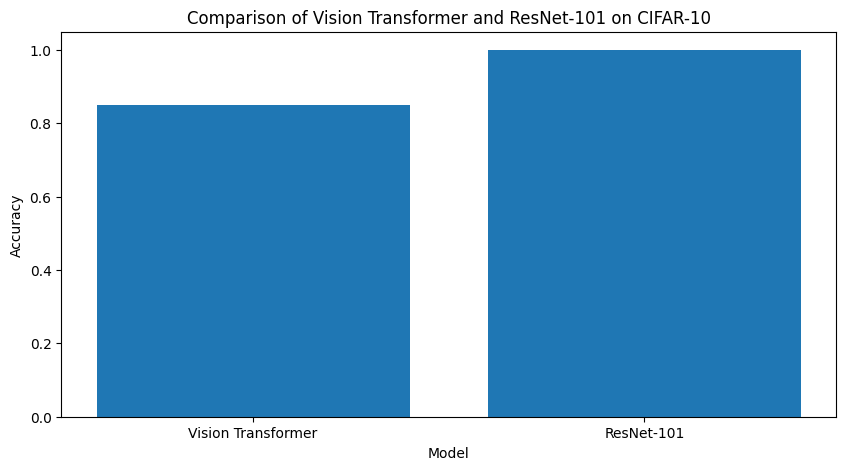

In [13]:
import matplotlib.pyplot as plt

# Example results (replace these with your actual results from training)
vit_accuracy = 0.85  # Replace with final accuracy from ViT
resnet_accuracy = accuracy_resnet  # Replace with final accuracy from ResNet

# Plotting
models = ['Vision Transformer', 'ResNet-101']
accuracies = [vit_accuracy, resnet_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Vision Transformer and ResNet-101 on CIFAR-10")
plt.show()


In [14]:
from transformers import ViTForImageClassification, ViTConfig
import torch

# Configuring the model with smaller patch size (e.g., 8x8 instead of 16x16)
config = ViTConfig.from_pretrained("google/vit-base-patch16-224")
config.patch_size = 8  # Change patch size

# Create the model with modified configuration
model = ViTForImageClassification(config)
model.num_labels = 10  # Set number of classes (e.g., CIFAR-10)

# Apply layer-wise learning rate decay
optimizer = torch.optim.AdamW(
    [
        {"params": model.embeddings.parameters(), "lr": 1e-5},  # lower lr for embeddings
        {"params": model.encoder.parameters(), "lr": 1e-4},     # moderate lr for encoder
        {"params": model.classifier.parameters(), "lr": 1e-3}   # higher lr for classifier
    ]
)


AttributeError: 'ViTForImageClassification' object has no attribute 'embeddings'